## Описание проекта
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру
компьютерные игры. Из открытых источников доступны исторические данные о
продажах игр, оценки пользователей и экспертов, жанры и платформы
(например, Xbox или PlayStation). Вам нужно выявить определяющие успешность
игры закономерности. Это позволит сделать ставку на потенциально популярный
продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы
планируете кампанию на 2017-й. Нужно отработать принцип работы с данными.
Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же
2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating
Board) — это ассоциация, определяющая возрастной рейтинг компьютерных
игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную
категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для
подростков».


In [1]:
# импорт библиотк
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime
from scipy import stats as st

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [2]:
df = pd.read_csv("https://code.s3.yandex.net/datasets/games.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [3]:
len(df[df.duplicated()])  # число явных дубликатов

0

In [4]:
missing_data = pd.DataFrame({'null_rate':df.isna().sum()/len(df)})
# missing_data['null_counts'] = df.isna().sum()
missing_data_sorted = missing_data.sort_values('null_rate').query('null_rate > 0')
missing_data_sorted['null_rate'] = missing_data_sorted['null_rate'].map(lambda x: '{:.2%}'.format(x))
print(f'В {len(missing_data_sorted)} показателях отсутствуют данные')
missing_data_sorted

В 6 показателях отсутствуют данные


,null_rate
Name,0.01%
Genre,0.01%
Year_of_Release,1.61%
User_Score,40.09%
Rating,40.48%
Critic_Score,51.32%


In [5]:
df.columns = df.columns.str.lower() # приведение названий колонок к стандартному виду (snake_style)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### **Вывод**
* данные представлены в одном файле
* 6 категорий имеют пропуски

## Подготовка данных

In [6]:
# df.year_of_release = df.year_of_release.astype('Int64')        # годы в целое число
# df.critic_score = df.critic_score.astype('Int64')              # оценка критиков в число с плавающей точкой
df.user_score = df.user_score.replace("tbd", np.NaN)           # замена строковой на NaN ('to be determined')
df.user_score = pd.to_numeric(df.user_score, errors='coerce')  # исправление ошибок
df.user_score = df.user_score.astype('Float64')                # оценка критиков в число с плавающей точкой
df.platform = df.platform.astype('str')                        # название платформы в строковую переменную

In [8]:
# добавление столбца total_sales с суммарными продажами
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,<NA>,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,<NA>,NaN,31.38


In [9]:
# обратим внимание на комбинаторность по параметрам "название игры", "год выпуска", "платформа" и "жанр"
df.groupby(['name', 'year_of_release', 'platform'])['genre'].count()\
    .to_frame().sort_values('genre', ascending=False).head()

,,,genre
name,year_of_release,platform,
Madden NFL 13,2012.0,PS3,2
Beyblade Burst,2016.0,3DS,1
Ratatouille,2007.0,PC,1
Rapala Tournament Fishing!,2006.0,X360,1
Rapala Trophies,2006.0,PSP,1


для заполнения пропусков все указанные категории важны, но данных в них  недостаточно. Так, максимальная комбинация состоит из 2-х значений, и если даже одно из них имеет числовое выражение, то заполнять даже в этом случае пропуски не имеет смылсла
`Year_of_Release`, `Critic_Score`, `User_Score`, `Rating` - оставим пропуски незаполненными

### **Вывод**
* данные приведены к необходиммым для анализа типам
* данные в 3-х категориях, важные для анализа, оставлены без заполнения из-за недостатка данных

## Исследовательский анализ данных

### Кол-во игр за весь период

Text(0.5, 0, 'Year')

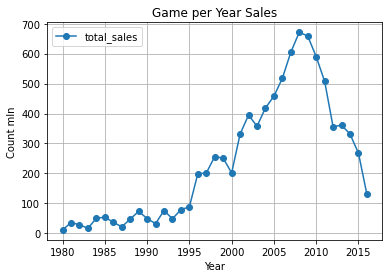

In [10]:
year_sales = df.groupby('year_of_release')[['total_sales']].sum()
year_sales.plot(style='o-', grid=True)
plt.title("Game per Year Sales")
plt.ylabel("Count mln")
plt.xlabel("Year")

Резкий подъем продаж начинается по результатам отчетного периода за 1996 г. В связи с этим возьмем данные, начиная с 1995 года.

Проанализируем наиболее успешные платформы по продажам на период с 1995г.


In [11]:
df_cut = df[df['year_of_release'] >= 1995]
platforms_total = df_cut.groupby(['platform'])['total_sales'].sum().sort_values(ascending=False)
#display(platforms_total.to_frame().reset_index().head(10))
summa = platforms_total.sum()            # сумма за выделенное время наблюдения

list = []                                # определим первые платформы, которые занимают 2/3 по сумме кол-ва продаж
k = 0
for i in range(len(platforms_total)):
    k += platforms_total[i]
    if k < summa * 2 / 3:
        list.append(i)
    else: break
print(list)

[0, 1, 2, 3, 4]


получаем, что 66% продаж в количетсвенном выражении за отчетный период занимают 5 платформ

In [12]:
platforms_top5_list = platforms_total.index[:5].to_list()
platforms_top5_list

['PS2', 'X360', 'PS3', 'Wii', 'DS']

In [13]:
platforms = df_cut.groupby(['platform','year_of_release'])['total_sales'].sum()
platforms = platforms.to_frame().reset_index()
platforms.head()

,platform,year_of_release,total_sales
0,3DO,1995.0,0.08
1,3DS,2011.0,63.20
2,3DS,2012.0,51.36
3,3DS,2013.0,56.57
4,3DS,2014.0,43.76


посстроим графики распределения продаж в млн.шт. по годам за отчетный период

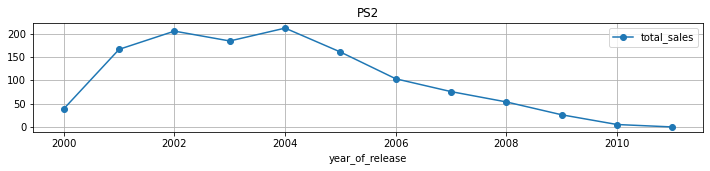

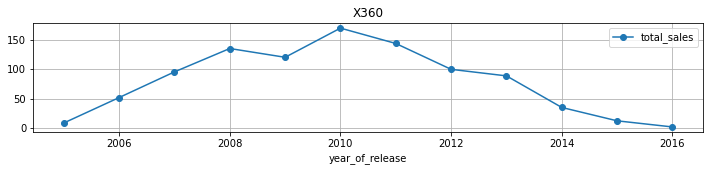

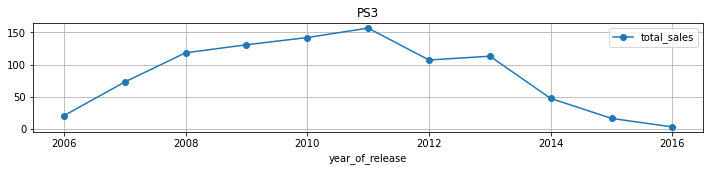

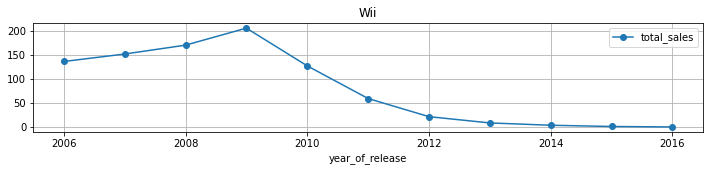

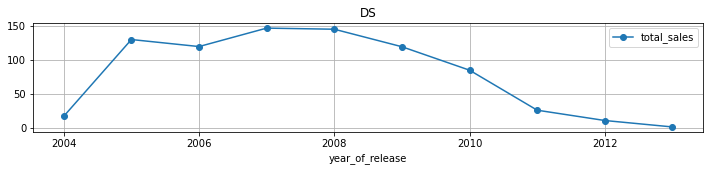

In [14]:
for platf in platforms_top5_list:
    x = platforms.query('platform == @platf')
    x.plot(x='year_of_release', y='total_sales', style='o-', title=platf, legend=True, grid=True, figsize=(12,2))

,index,platform,year_of_release,total_sales,market_share
3,113,PS4,2016.0,69.25,53.29%
8,186,XOne,2016.0,26.15,20.12%
0,6,3DS,2016.0,15.14,11.65%
1,76,PC,2016.0,5.25,4.04%
6,161,WiiU,2016.0,4.60,3.54%


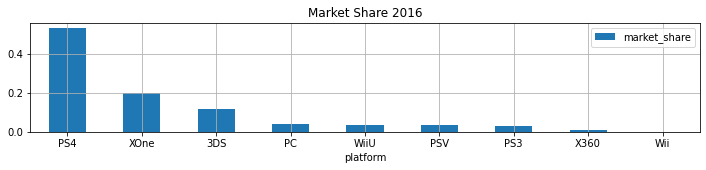

In [15]:
sales2016 = platforms.query('year_of_release == 2016')
sales2016 = sales2016.copy()
sales2016['market_share'] = sales2016.total_sales / sales2016.total_sales.sum()
sales2016 = sales2016.reset_index().sort_values('market_share', ascending=False)
sales2016.plot(x='platform', y='market_share', grid = True, kind = 'bar', title="Market Share 2016", figsize=(12,2), rot=0)
sales2016['market_share'] = sales2016['market_share'].map(lambda x: '{:.2%}'.format(x))
sales2016.head()

Теперь обратим внимание на платформы за пределами среза ТОП-5. Для наглядности также получим визуальное отображение результатов их активности на потребительском рынке

In [16]:
platforms_bottom_list = platforms_total.index[5:].to_list()
print('Кол-во платформ аутсайдеров: ', len(platforms_bottom_list))

Кол-во платформ аутсайдеров:  21


Обратим внимание на общие продажи в шт. за отчетный период

Text(0.5, 1.0, 'Total Sales since 1995 to 2016')

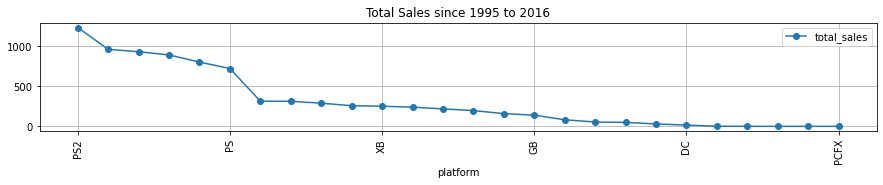

In [17]:
platforms_total.plot(x='year_of_release',
                     y='total_sales',
                     style='o-',
                     legend=True,
                     grid=True,
                     figsize=(15,2),
                    rot=90)
plt.title("Total Sales since 1995 to 2016")

чтобы иметь возможность оценить, в каком направлении идут продажи у какой-либо платформы, возьмем только те из них, которые имеют статистику хотя бы за 10 лет

In [18]:
df_platforms_bottom = platforms.groupby(['platform'])['year_of_release'].count()
df_platforms_bottom_cut10 = df_platforms_bottom.to_frame().query('year_of_release >= 10').reset_index()
# df_platforms_bottom_cut10
platforms_bottom_list = df_platforms_bottom_cut10.platform.to_list()
print('Кол-во платформ с доступными данными за 10 лет: ', len(platforms_bottom_list))

Кол-во платформ с доступными данными за 10 лет:  7


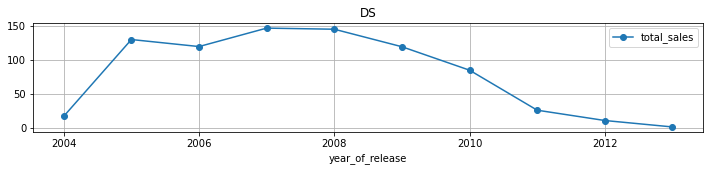

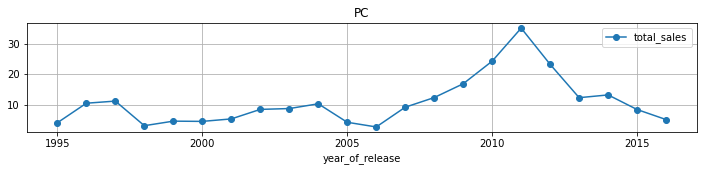

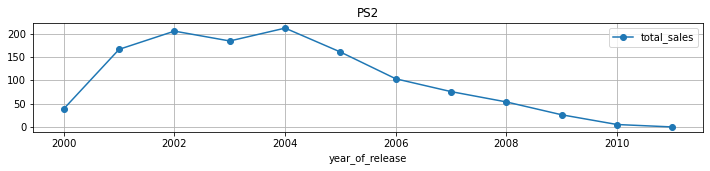

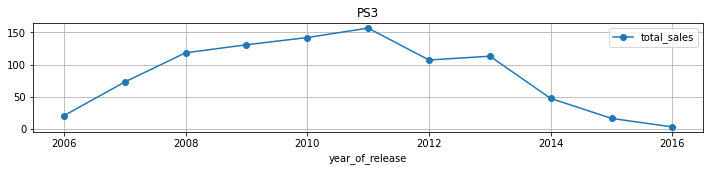

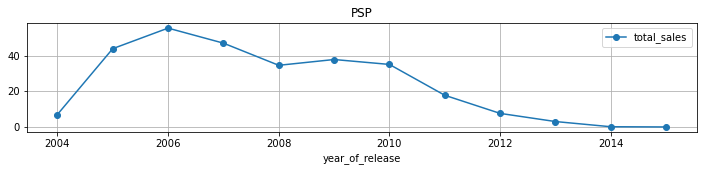

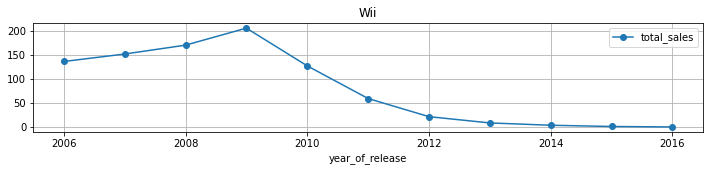

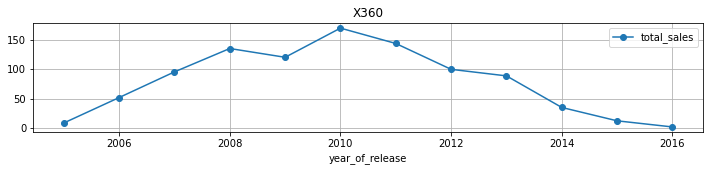

In [19]:
for platf in platforms_bottom_list:
    x = platforms.query('platform == @platf')
    x.plot(x='year_of_release', y='total_sales', style='o-', title=platf, legend=True, grid=True, figsize=(12,2))

Так же, как и в ТОП-5, остальные платформы, для которых достаточно данных, показывают падение продаж в абсолютном выражении

по представленным в датасете данным невозможно сделать вывод о прибыльности, но только лишь о продажах, так как не представлена статистика прибыли платформ

In [20]:
print('Медианное время жизни платформы (г.): ', df.groupby('platform')['year_of_release'].nunique().median())
print('Максимальное время жизни платформы (г.): ', df.groupby('platform')['year_of_release'].nunique().max())
print('Минимальное время жизни платформы (г.): ', df.groupby('platform')['year_of_release'].nunique().min())

Медианное время жизни платформы (г.):  7.0
Максимальное время жизни платформы (г.):  26
Минимальное время жизни платформы (г.):  1


Тепловая карта распределения продаж и времени жизни платформ


<AxesSubplot:xlabel='year_of_release', ylabel='platform'>

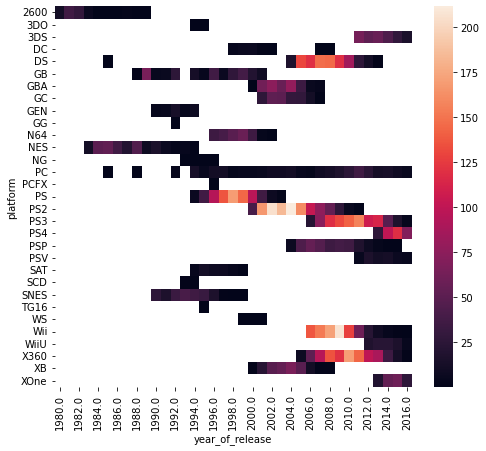

In [21]:
print('Тепловая карта распределения продаж и времени жизни платформ')
heatmap_all_data=df.pivot_table(index="platform",columns='year_of_release',values='total_sales',aggfunc=('sum'))
plt.figure(figsize=(8,7))
sns.heatmap(heatmap_all_data)

В соответствии с условиями задачи необходимо принимать в расчет действующие на рынке платформы, в связи с чем в дальнейше работе возьмем актуальные данные, соответствующие периоду, начиная с 2013 года.

Тепловая карта распределения продаж и времени жизни платформ с 2013 года


<AxesSubplot:xlabel='year_of_release', ylabel='platform'>

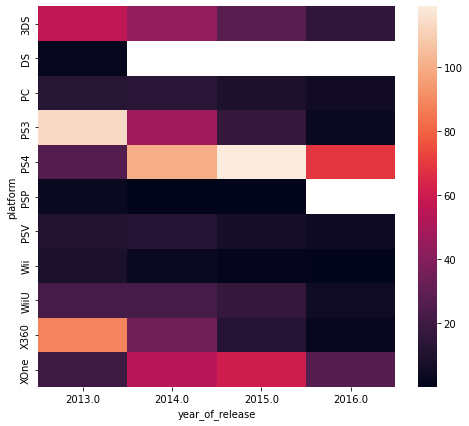

In [22]:
print('Тепловая карта распределения продаж и времени жизни платформ с 2013 года')
heatmap_data_since2013=df[df['year_of_release'] >= 2013].pivot_table(index="platform",columns='year_of_release',values='total_sales',aggfunc=('sum'))
plt.figure(figsize=(8,7))
sns.heatmap(heatmap_data_since2013)


### **Вывод**
* Лидеры рынка, занимающие в отчетный период первые 5 мест по продажам в количественном выражении, находятся в стадии спада по продажам
* приблизительный период жизни платформы составляет порядка 7 лет
* некоторые платформы имеют неярко выраженный всплеск продаж, являются изначально популярными ("Wii" платформа), что может свидетельствовать о лояльности потребителя и/или эффективной маркетинговой политике компании по продвижению собственного продукта среди пользователей
* исходя из доли рынка по количеству проданных продуктов можно рассматривать 3 платформы как перспективные: PS4, XOne и 3DS
* по представленным в датасете данным невозможно сделать вывод о прибыльности, но только лишь о продажах, так как не представлена статистика прибыли платформ
* на 2016 год лидирует платформа PS4 с продажами более 54% объема рынка в штучном выражении

## Глобальные продажи игр в разбивке по платформам

Построим графики для ТОП-5 для актуального периода

In [23]:
# print("Продажи в млн.шт. за период: 1995-2016гг.")
# print()
# # Отображение ТОП-5 платформ по продажам  ------------------------------------------------------------------
# for platf in range(len(platforms_top5_list)):
#     print('Top-5, место №', platf+1,',', platforms_top5_list[platf],\
#           np.round(platforms.loc[platforms['platform'] == platforms_top5_list[platf]]['total_sales'].sum()))
# # создание словаря из названия платформ и данными по продажам ----------------------------------------------
# dict_top5_list = {}
# for platf in platforms_top5_list:
#     dict_top5_list[platf] = pd.Series(platforms.query('platform == @platf').total_sales)
# # график ---------------------------------------------------------------------------------------------------
# pd.DataFrame(dict_top5_list).plot.box(figsize=(12, 3), grid=True)
# plt.ylabel("Total_Sales")
# plt.title('TOP-5 TotalSalesTOP-5')
# plt.show()

In [24]:
heatmap_data_since2013 = heatmap_data_since2013.reset_index()
heatmap_data_since2013['total'] = heatmap_data_since2013.loc[:,2013:2016].sum(axis=1)
top5 = heatmap_data_since2013.sort_values('total', ascending=False).head(5)
top5_list = top5.platform.tolist()
top5_list

['PS4', 'PS3', 'XOne', '3DS', 'X360']

In [25]:
df_top5_platf = df[df['platform'].isin(top5_list)]
df_top5_platf = df_top5_platf[df_top5_platf['total_sales']<2]


Text(0, 0.5, 'Sales')

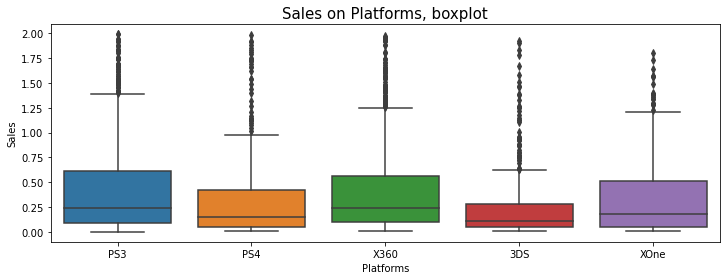

In [26]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df_top5_platf, x='platform', y='total_sales')
plt.title('Sales on Platforms, boxplot', fontsize=15)
plt.xlabel('Platforms', fontsize=10)
plt.ylabel('Sales',fontsize=10)

Text(0, 0.5, 'Sales')

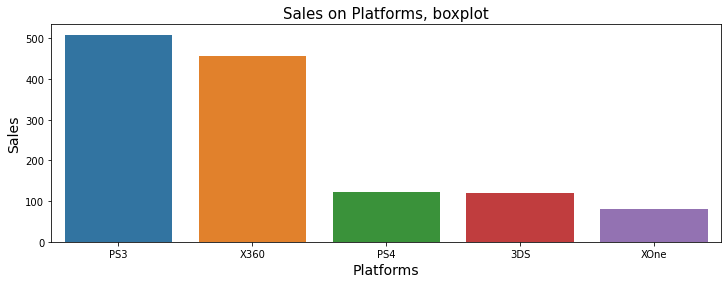

In [27]:
plt_top5 = df_top5_platf.groupby('platform')['total_sales'].sum()
plt_top5.sort_values(ascending=False, inplace=True)
plt_top5 = plt_top5.reset_index()

plt.figure(figsize=(12,4))
sns.barplot(data=plt_top5, y='total_sales', x='platform')
plt.title('Sales on Platforms, boxplot', fontsize=15)
plt.xlabel('Platforms', fontsize=14)
plt.ylabel('Sales',fontsize=14)

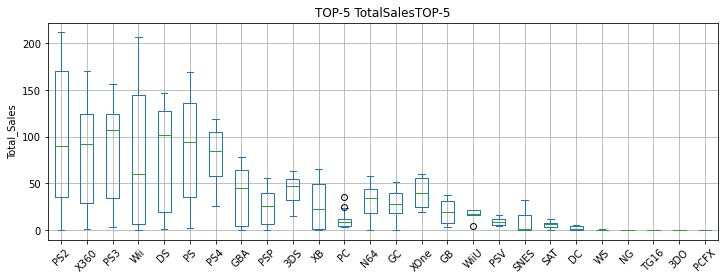

In [28]:
platforms_total_list = platforms_total.index.to_list()
dict_total_list = {}
for platf in platforms_total_list:
    dict_total_list[platf] = pd.Series(platforms.query('platform == @platf').total_sales)
    
pd.DataFrame(dict_total_list).plot.box(figsize=(12, 4), grid=True)
plt.ylabel("Total_Sales")
plt.title('TOP-5 TotalSalesTOP-5')
plt.xticks(rotation=45)
plt.show()

### **Вывод**
* Имеются явные выбросы, что говорит об успешности различных продуктов (name), выпущенных для одной и той же платформы в разные годы, на разных платформах, различных жанров
* Медианные значения ТОП-5 показали различие, однако в совокупности с шириной межквартильного размаха и его положением в вертикальной плоскости указывает, что медианное значение может отличаться в меньшую сторону, в то время как продукт на определенной платформе будет продаваться лучше, о чем свидетельствуют графики

## Взаимосвязь различных параметров
### Влияние отзывов на продажи внутри одной платформы
Выбирем для анализа лидера за отчетный период - PS3

Диаграмма рассеяния для PS3


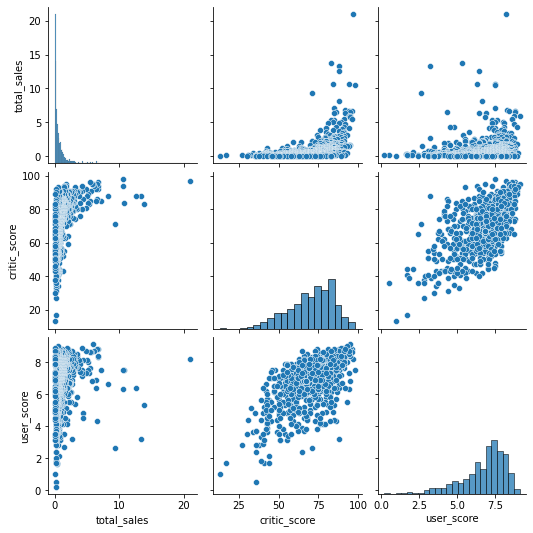

In [29]:
print("Диаграмма рассеяния для PS3")
sns.pairplot(df.query('platform == "PS3"')[['total_sales', 'critic_score', 'user_score']])
plt.show()

Матрица корреляций


,total_sales,critic_score,user_score
total_sales,1.000000,0.334285,0.002394
critic_score,0.334285,1.000000,0.599920
user_score,0.002394,0.599920,1.000000


Text(0.5, 1.0, 'PS3')

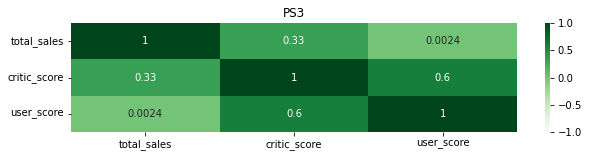

In [30]:
df_cut = df[df['year_of_release'] >= 2013]
print("Матрица корреляций")
correlation_df = df_cut.query('platform == "PS3"')[['total_sales', 'critic_score', 'user_score']].corr()
display(correlation_df)
fig, ax = plt.subplots(figsize=(10,2))
sns.heatmap(correlation_df, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'Greens')
ax.set_title('PS3')

#### **Вывод**
* Можно сделать вывод, что в основном оценка критиков и пользователей связаны между собой: меньшие показатели отзывов критиков зачастую соответствуют меньшим показателям отзыва пользователей, что так же влияет на продажи. Однако отзывы критиков не влияют на продажи в отличии от отзывов пользователей.


### Соотнесем полученные результаты с другими платформами из ТОП-5

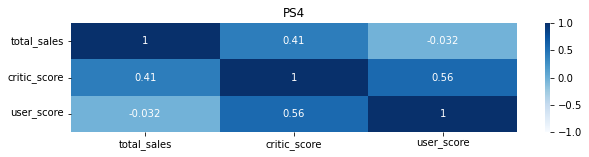

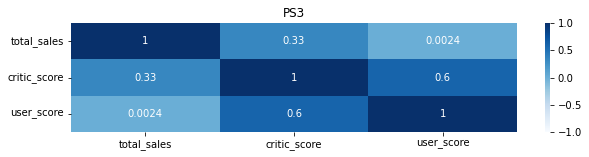

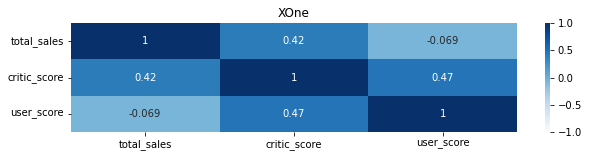

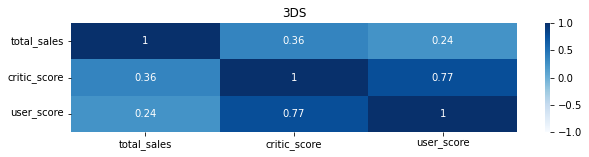

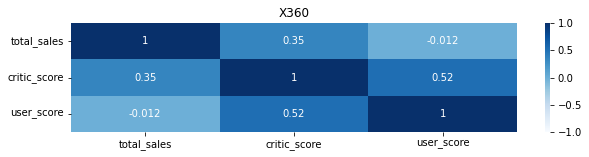

In [31]:
for platf in top5_list:
    x = df_cut.query('platform == @platf')[['total_sales', 'critic_score', 'user_score']].corr()
    fig, ax = plt.subplots(figsize=(10,2))
    sns.heatmap(x, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'Blues')
    ax.set_title(platf)

#### **Вывод**
Картина похожая для всех ТОП-5 платформ

### Распределение игр по жанрам

<AxesSubplot:ylabel='share'>

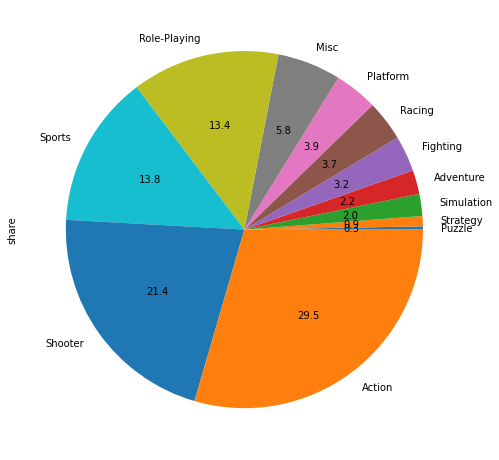

In [32]:
df_genre = df_cut.groupby('genre')['total_sales'].sum().to_frame()
sum_ = df_genre.total_sales.sum()
df_genre['share'] = df_genre / sum_*100
df_genre = df_genre.sort_values('share')
df_genre.plot.pie(y='share', figsize=(8, 10), rot=45, autopct="%.1f", legend=False)

In [33]:
df_genre = df_cut.groupby('genre')['total_sales'].median().to_frame()
df_genre = df_genre.sort_values('total_sales', ascending=False).reset_index()
df_genre.head()

,genre,total_sales
0,Shooter,0.450
1,Sports,0.240
2,Platform,0.225
3,Role-Playing,0.125
4,Fighting,0.125


Text(0, 0.5, 'Sales')

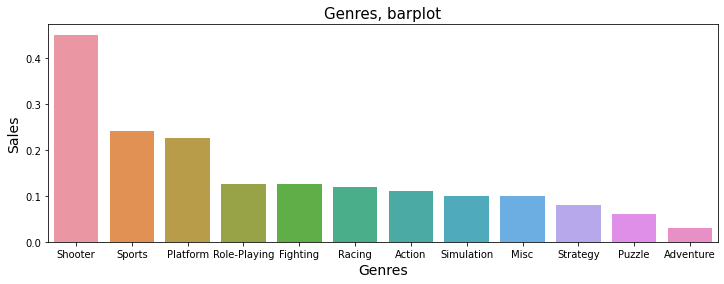

In [34]:
plt.figure(figsize=(12,4))
sns.barplot(data=df_genre, y='total_sales', x='genre')
plt.title('Genres, barplot', fontsize=15)
plt.xlabel('Genres', fontsize=14)
plt.ylabel('Sales',fontsize=14)

#### **Вывод**
* Минимальный объем продаж за отчетный период показали такие жанры, как: Puzzle, Strategy, Adventure
* Максимальный: Shooter, Sport, Platform

## Портрет пользователя
### Популярные платформы ТОП-5 по регионам

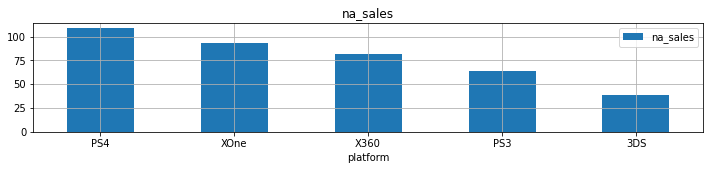

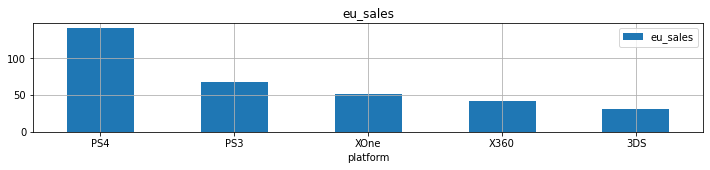

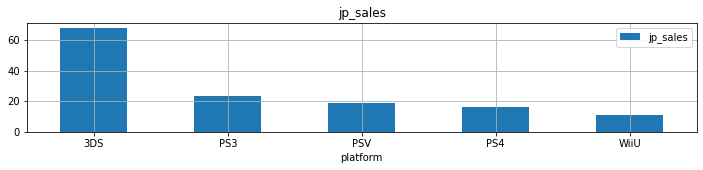

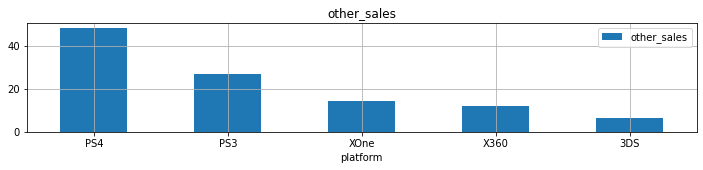

In [35]:
regions_list = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
for reg in regions_list:
    #print(reg)
    df_reg = df_cut.groupby(['platform'])[reg].sum().to_frame().sort_values(reg, ascending=False)[:5].reset_index()
    #display(df_reg)
    df_reg.plot(x='platform', y=reg, grid = True, kind = 'bar', title=reg, figsize=(12,2))
    plt.xticks(rotation=0)


#### **Вывод**
* в Северной Америке, в Европе и других регионах популярна PS4
* в Японии - 3DS

### Популярные жанры ТОП-5 по регионам

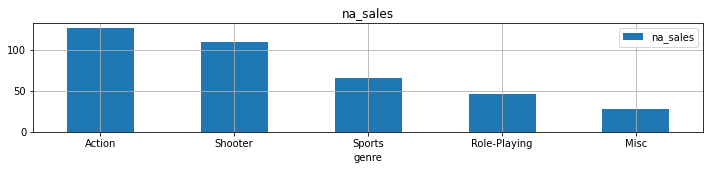

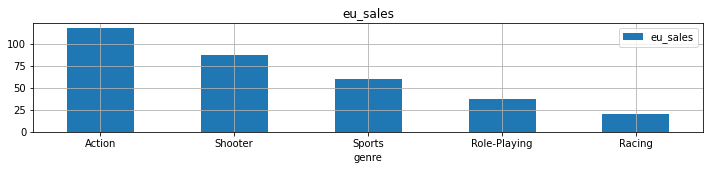

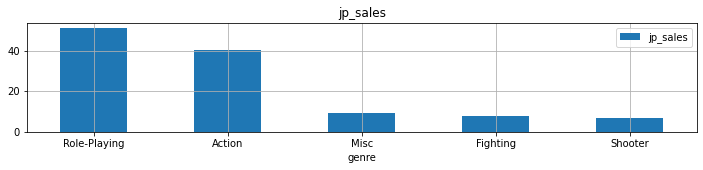

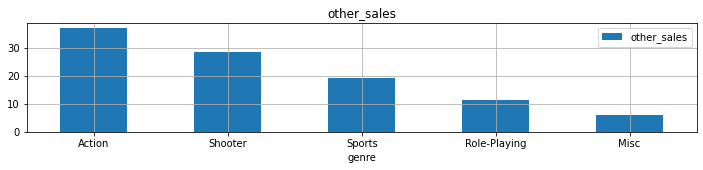

In [36]:
for reg in regions_list:
    #print(reg)
    df_gen = df_cut.groupby(['genre'])[reg].sum().to_frame().sort_values(reg, ascending=False)[:5].reset_index()
    #display(df_gen)
    df_gen.plot(x='genre', y=reg, grid = True, kind = 'bar', title=reg, figsize=(12,2))
    plt.xticks(rotation=0)

#### **Вывод**
* Лидеры по жанрам так же имеют отличия: Сев.Ам., Европа и друие страны - **Action**, Shooter, Sports, Япония - **Role-Playing**, **Action**, **Misc**

### Связь рейтинга ESRB и продаж в каждом регионе
В категории rating есть пропущенные значения. Заполним их значением 'not_set' - не установлено.

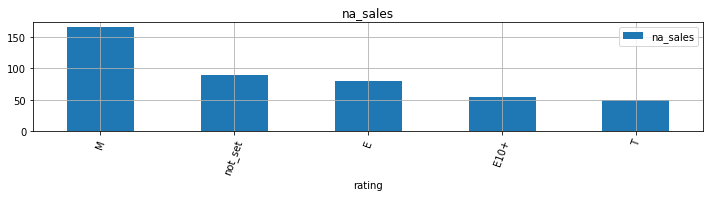

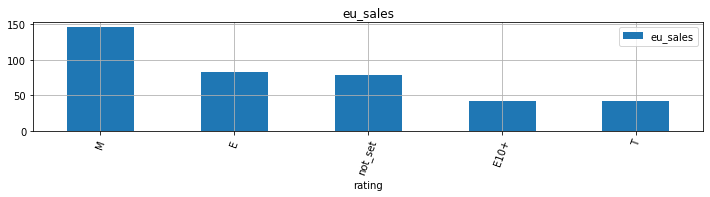

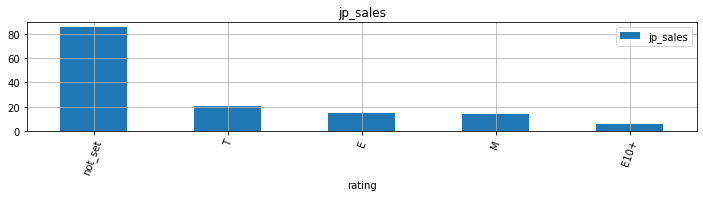

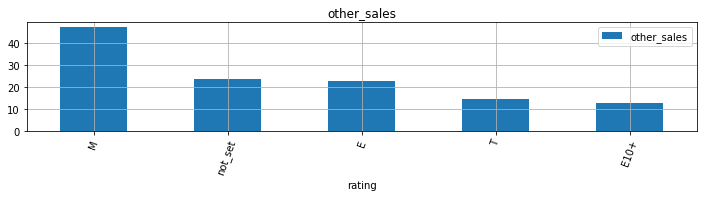

In [37]:
df_cut = df_cut.copy()
df_cut.rating = df_cut.rating.fillna('not_set')
for reg in regions_list:
    df_rating = df_cut.groupby('rating')[reg].sum().to_frame().sort_values(reg, ascending=False).reset_index()
    #display(df_rating)
    df_rating.plot(x='rating', y=reg, grid = True, kind = 'bar', title=reg, figsize=(12,2))
    plt.xticks(rotation=70)

***Памятка:***

использованные рейтинги соответствуют ранжированию системы Entertainment Software Rating Board, в которые используются следующие оценки:
* **«EC»** («Early childhood») — «Для детей младшего возраста»
* **«E»** («Everyone») — «Для всех»
* **«E10+»** («Everyone 10 and older») — «Для всех от 10 лет и старше»
* **«T» («Teen»)** — «Подросткам»
* **«M» («Mature»)** — «Для взрослых»
* **«AO» («Adults Only 18+»)** — «Только для взрослых»
* **«RP»** («Rating Pending») — «Рейтинг ожидается»

https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board

актуально на момент создания данного проекта (2022.03)

некоторые рейтинги, присутствующие в представленном для анализа датасете, в актуальной на момент создания данного проекта версии статьи Wikipedia отсутствуют

#### **Вывод**
* В большенстве регионов исследования наиболее популярными продуктами являются продукты с рейтингом "M", кроме региона Япония, где наиболее популярны продукты без пометки категории использования/направленности
* Во всех регионах исследования основными продуктами являются продукты с пометками "Е", "М", "Т" (см. памятку) и некатегоризированные

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

$Н_{0}$ - нулевая гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

$Н_{1}$ - отличаются

Исходя из предполагаемой верности $Н_{0}$ для пользователей Xbox расчитаем вероятность появления среднего значения 
рейтинга пользователей РС в соответствующем распределении пользователей Xbox

Отметим, что данные выборки также являются независимыми  - наборы данных двух групп пользоваталей (кластеров) за отчетный период.

Возьмем пороговый уровень значимости за 1%

Также будем исходить из неравенства дисперсий выборок

In [38]:
# df_cut = df[df['year_of_release'] >= 2013]
xbox_sample = df_cut.query('platform == "XOne"')['user_score'].dropna()
pc_sample = df_cut.query('platform == "PC"')['user_score'].dropna()

print('Дисперсия для "Xbox"', np.var(xbox_sample, ddof=1))
print('Дисперсия для "PC"', np.var(pc_sample, ddof=1))
print()
print('Ст.отклоненеие для "Xbox"', np.std(xbox_sample, ddof=1))
print('Ст.отклоненеие "PC"', np.std(pc_sample, ddof=1))
print()
alpha = 0.01

result = st.ttest_ind(xbox_sample, pc_sample, equal_var = False) # дисперсии не равны по умолчанию
if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Вероятность равна ", result.pvalue)
else:
    print("Не получилось отвергнуть нулевую гипотезу. Вероятность равна ", np.round(result.pvalue*100), "%")

Дисперсия для "Xbox" 1.9069968429360695
Дисперсия для "PC" 3.035892752408882

Ст.отклоненеие для "Xbox" 1.380940564592144
Ст.отклоненеие "PC" 1.7423813452883619

Не получилось отвергнуть нулевую гипотезу. Вероятность равна  15.0 %


Если указать равенство дисперсий, то пулчаем большую вероятность

In [39]:
xbox_sample = df_cut.query('platform == "XOne"')['user_score'].dropna()
pc_sample = df_cut.query('platform == "PC"')['user_score'].dropna()

print('Дисперсия для "Xbox"', np.var(xbox_sample, ddof=1))
print('Дисперсия для "PC"', np.var(pc_sample, ddof=1))

alpha = 0.01

result = st.ttest_ind(xbox_sample, pc_sample, equal_var = True) # дисперсии не равны по умолчанию
if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Вероятность равна ", result.pvalue)
else:
    print("Не получилось отвергнуть нулевую гипотезу. Вероятность равна ", np.round(result.pvalue*100), "%")

Дисперсия для "Xbox" 1.9069968429360695
Дисперсия для "PC" 3.035892752408882
Не получилось отвергнуть нулевую гипотезу. Вероятность равна  14.0 %


### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные


$Н_{0}$ - нулевая гипотеза: Средние пользовательские рейтинги жанров Action и Sports одинаковые

$Н_{1}$ - отличаются

Исходя из предполагаемой верности $Н_{0}$ для жанра Action расчитаем вероятность появления среднего значения 
рейтинга жанра Sports в соответствующем распределении жанра Action 

Отметим, что данные выборки также являются независимыми  - наборы данных двух групп пользоваталей (кластеров) за отчетный период.

Возьмем пороговый уровень значимости за 1%

Также будем исходить из неравенства дисперсий выборок

In [40]:
action_sample = df_cut.query('genre == "Action"')['user_score'].dropna()
sports_sample = df_cut.query('genre == "Sports"')['user_score'].dropna()

print('Дисперсия для "Action"', np.var(action_sample, ddof=1))
print('Дисперсия для "Sports"', np.var(sports_sample, ddof=1))
print()
print('Ст.отклоненеие для "Action"', np.std(xbox_sample, ddof=1))
print('Ст.отклоненеие "Sports"', np.std(pc_sample, ddof=1))
print()
alpha = 0.01

result = st.ttest_ind(action_sample, sports_sample, equal_var = False) # дисперсии не равны по умолчанию
if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Вероятность равна ", result.pvalue)
else:
    print("Не получилось отвергнуть нулевую гипотезу. Вероятность равна ", np.round(result.pvalue*100), "%")

Дисперсия для "Action" 1.7693609042482705
Дисперсия для "Sports" 3.180612814465409

Ст.отклоненеие для "Action" 1.380940564592144
Ст.отклоненеие "Sports" 1.7423813452883619

Отвергаем нулевую гипотезу. Вероятность равна  1.4460039700700163e-20


Если указать равенство дисперсий, то пулчаем меньшую вероятность, но, тем не менее, достаточно высокую, чтобы не отвергать нулевую гипотезу, то есть:

In [41]:
action_sample = df_cut.query('genre == "Action"')['user_score'].dropna()
sports_sample = df_cut.query('genre == "Sports"')['user_score'].dropna()

print('Дисперсия для "Action"', np.var(action_sample, ddof=1))
print('Дисперсия для "Sports"', np.var(sports_sample, ddof=1))

alpha = 0.01

result = st.ttest_ind(action_sample, sports_sample, equal_var = True) # дисперсии не равны по умолчанию
if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Вероятность равна ", result.pvalue)
else:
    print("Не получилось отвергнуть нулевую гипотезу. Вероятность равна ", np.round(result.pvalue*100), "%")

Дисперсия для "Action" 1.7693609042482705
Дисперсия для "Sports" 3.180612814465409
Отвергаем нулевую гипотезу. Вероятность равна  1.0517832389135652e-27


### **Вывод**

1. Средние пользовательские рейтинги платформ Xbox One и PC с достаточно большой вероятностю не отличаются, что наглядно показано в результате стат.анализа при выборе строгово уровня значимости в 1%. P.value ~ 15%
2. Средние пользовательские рейтинги жанров Action и Sports скорее отличаются, так как вероятность отличной гепотизы оказалась начтожна (стремится к 0).

## **Общий вывод**

* данные представлены в одном файле
* 6 категорий имеют пропуски
* данные приведены к необходиммым для анализа типам
* данные в 3-х категориях, важные для анализа, оставлены без заполнения из-за недостатка данных

**Исследовательский анализ данных**

* Лидеры рынка, занимающие в отчетный период первые 5 мест по продажам в количественном выражении, находятся в стадии спада по продажам
* приблизительный период жизни платформы составляет порядка 8-10 лет
* некоторые платформы имеют неярко выраженный всплеск продаж, являются изначально популярными ("Wii" платформа), что может свидетельствовать о лояльности потребителя и/или эффективной маркетинговой политике компании по продвижению собственного продукта среди пользователей
* исходя из доли рынка по количеству проданных продуктов можно рассматривать 3 платформы как перспективные: PS4, XOne и 3DS
* по представленным в датасете данным невозможно сделать вывод о прибыльности, но только лишь о продажах, так как не представлена статистика прибыли платформ
* на 2016 год лидирует платформа PS4 с продажами более 54% объема рынка в штучном выражении

**Глобальные продажи игр в разбивке по платформам**
* Имеются явные выбросы, что говорит об успешности различных продуктов (name), выпущенных для одной и той же платформы в разные годы, на разных платформах, различных жанров
* Медианные значения ТОП-5 показали различие, однако в совокупности с шириной межквартильного размаха и его положением в вертикальной плоскости указывает, что медианное значение может отличаться в меньшую сторону, в то время как продукт на определенной платформе будет продаваться лучше, о чем свидетельствуют графики

**Влияние отзывов на продажи внутри одной платформы**
* Можно сделать вывод, что в основном оценка критиков и пользователей связаны между собой: меньшие показатели отзывов критиков зачастую соответствуют меньшим показателям отзыва пользователей, что так же влияет на продажи. Однако отзывы критиков не влияют на продажи в отличии от отзывов пользователей.
* Картина похожая для всех ТОП-5 платформ
* Минимальный объем продаж за отчетный период показали такие жанры, как: Puzzle, Strategy, Adventure
* Максимальный: Shooter, Sport, Platform

**Портрет пользователя**
* в Северной Америке, в Европе и других регионах популярна PS4
* в Японии - 3DS
* Лидеры по жанрам так же имеют отличия: Сев.Ам., Европа и друие страны - **Action**, Shooter, Sports, Япония - **Role-Playing**, **Action**, **Misc**
* В большенстве регионов исследования наиболее популярными продуктами являются продукты с рейтингом "M", кроме региона Япония, где наиболее популярны продукты без пометки категории использования/направленности
* Во всех регионах исследования основными продуктами являются продукты с пометками "Е", "М", "Т" (см. памятку) и некатегоризированные


**Средний пользовательский рейтинг платформ и жанров**
1. Средние пользовательские рейтинги платформ Xbox One и PC с достаточно большой вероятностю не отличаются, что наглядно показано в результате стат.анализа при выборе строгово уровня значимости в 1%. P.value ~ 15%
2. Средние пользовательские рейтинги жанров Action и Sports скорее отличаются, так как вероятность отличной гепотизы оказалась начтожна (стремится к 0).


